## 市场宽度
*对市场内股票数据进行统计，观察样本变化。*

## 目录
1. 什么是市场宽度？
2. 数据预处理
3. 市场宽度计算公式
4. 如何用图形展示市场宽度？

## 1_什么是市场宽度？
市场宽度指标指某一日收盘时，显示某指数组合的股票的上涨数量与下跌数量的比率，有比较准确预测大盘行情的功能。

### 怎么计算市场宽度？

**1. Advance & Decline Percent (Participation)**

$\frac{(Advance-Decline)}{Total}$

**2. High & Low Percent (Leadership)**

$\frac{(High-Low)}{Total}$

**3. MA50_up & MA50_down Percent (Trend)**

$\frac{(MA50_{up}-MA50_{down})}{Total}$

## 2_数据预处理

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pymongo
import pandas as pd
from datetime import datetime

In [3]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [4]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [5]:
startTime = datetime(2022,12,25)
endTime = datetime(2023,1,2)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [6]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [7]:
# crytoDict

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = df.set_index('datetime')
    dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
def cal_pt(positive, total):
    return positive/total

def cal_pnPct(positive, negative, total):
    return (positive-negative)/total

def sumrows(frame):
    return frame.sum(axis=1)

## 3_市场宽度计算公式

In [32]:
periodList = [24, 72, 120, 192, 312]
symbolCount = 10

In [33]:
highPrice = multiDf['high'].unstack()
lowPrice = multiDf['low'].unstack()
closePrice = multiDf['close'].unstack()

In [35]:
# 1. Percent/Number of Stocks above Moving Average
#MA10
def cal_ma(data, timeperiod):
    data = data.dropna()
    return data.rolling(timeperiod).mean()
#     except:
#         return pd.Series()

maPeriodDict = {}
for hour in periodList:
    ma = cal_ma(closePrice, hour)
    maPeriodDict[hour] = cal_pt(sumrows(closePrice>ma), symbolCount)

weeklyMaUpPct = pd.DataFrame(maPeriodDict)
weeklyMaUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']
print(weeklyMaUpPct)

                     1Day  3Day  5Day  8Day  13Day
datetime                                          
2022-12-25 00:01:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:02:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:03:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:04:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:05:00   0.0   0.0   0.0   0.0    0.0
...                   ...   ...   ...   ...    ...
2023-01-01 23:55:00   0.7   0.8   0.7   0.7    0.6
2023-01-01 23:56:00   0.8   0.9   1.0   0.8    0.8
2023-01-01 23:57:00   0.9   0.9   1.0   0.8    0.8
2023-01-01 23:58:00   0.9   0.9   0.9   0.8    0.8
2023-01-01 23:59:00   0.9   0.9   1.0   0.8    0.8

[11519 rows x 5 columns]


<AxesSubplot:xlabel='datetime'>

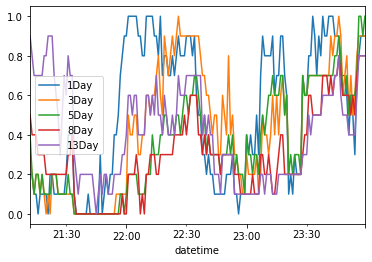

In [36]:
weeklyMaUpPct.iloc[-168:].plot()

In [37]:
maDayChange = round((weeklyMaUpPct.iloc[-1]-weeklyMaUpPct.iloc[-168])/weeklyMaUpPct.iloc[-1],2)
maDayChangeDf = maDayChange.to_frame()
maDayChangeDf.columns = ['maUpPctChange']

In [38]:
maDayChangeDf.T

,1Day,3Day,5Day,8Day,13Day
maUpPctChange,0.78,0.67,0.6,0.38,-0.12


In [39]:
# 2. Percent/Number of Stocks above Relative Strength

def cal_pct(data, period):
    return data.pct_change(period)

rsDf = pd.DataFrame({name: closePrice[name]/closePrice['btc'] for name in closePrice.columns})
rsDf['btc'] = closePrice['btc']
rsPeriodDict = {}

for hour in periodList:
    rsPeriodDict[hour] = cal_pt(sumrows(cal_pct(rsDf, hour)>0), symbolCount)
weeklyRsUpPct = pd.DataFrame(rsPeriodDict)
weeklyRsUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# print(weeklyRsUpPct)

<AxesSubplot:xlabel='datetime'>

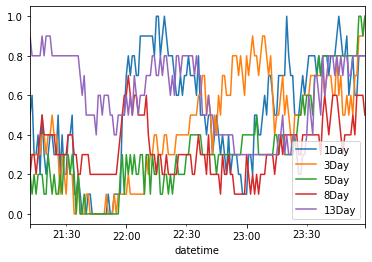

In [40]:
weeklyRsUpPct.iloc[-168:].plot()

In [41]:
rsDayChange = round((weeklyRsUpPct.iloc[-1]-weeklyRsUpPct.iloc[-168])/weeklyRsUpPct.iloc[-1],2)
rsDayChangeDf = rsDayChange.to_frame()
rsDayChangeDf.columns = ['rsUpPctChange']

In [42]:
rsDayChangeDf.T

,1Day,3Day,5Day,8Day,13Day
rsUpPctChange,0.38,0.7,0.8,0.6,-0.12


In [43]:
# 3. Periodic High and Low
import numpy as np
def cal_shochastic(data, period):
    return ((data - data.rolling(period).min())/(data.rolling(period).max()-data.rolling(period).min()))*100

hlRangePeriodDict = {}

for hour in periodList:
    hlRangePeriodDict[hour] = cal_pnPct(sumrows(cal_shochastic(closePrice, hour)>80), 
                                     sumrows(cal_shochastic(closePrice, hour)<20), symbolCount)
weekly_hlRangePct = pd.DataFrame(hlRangePeriodDict)
weekly_hlRangePct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

print(weekly_hlRangePct)

                     1Day  3Day  5Day  8Day  13Day
datetime                                          
2022-12-25 00:01:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:02:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:03:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:04:00   0.0   0.0   0.0   0.0    0.0
2022-12-25 00:05:00   0.0   0.0   0.0   0.0    0.0
...                   ...   ...   ...   ...    ...
2023-01-01 23:55:00   0.1   0.5   0.5   0.2    0.2
2023-01-01 23:56:00   0.8   0.8   0.6   0.5    0.3
2023-01-01 23:57:00   0.8   0.9   0.6   0.6    0.4
2023-01-01 23:58:00   0.8   0.8   0.6   0.5    0.4
2023-01-01 23:59:00   0.5   0.8   0.5   0.4    0.3

[11519 rows x 5 columns]


<AxesSubplot:xlabel='datetime'>

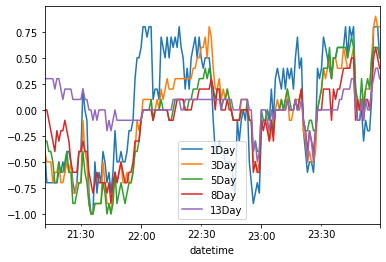

In [44]:
weekly_hlRangePct.iloc[-168:].plot()

In [45]:
hlDayChange = round((weekly_hlRangePct.iloc[-1]-weekly_hlRangePct.iloc[-168])/weekly_hlRangePct.iloc[-1],2)
hlDayChangeDf = hlDayChange.to_frame()
hlDayChangeDf.columns = ['hlRangePctChange']

In [46]:
hlDayChangeDf.T

,1Day,3Day,5Day,8Day,13Day
hlRangePctChange,1.8,1.5,1.6,1.0,0.0


In [47]:
# 4. Advance/Decline

def cal_pct(data, period):
    return data.pct_change(period)

adPeriodDict = {}

for hour in periodList:
    adPeriodDict[hour] = cal_pt(sumrows(cal_pct(closePrice, hour)>0), symbolCount)
weeklyAdPct = pd.DataFrame(adPeriodDict)
weeklyAdPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# print(weeklyRsUpPct)

<AxesSubplot:xlabel='datetime'>

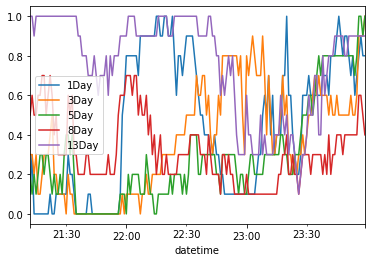

In [48]:
weeklyAdPct.iloc[-168:].plot()

In [49]:
adDayChange = round((weeklyAdPct.iloc[-1]-weeklyAdPct.iloc[-168])/weeklyAdPct.iloc[-1],2)
adDayChangeDf = adDayChange.to_frame()
adDayChangeDf.columns = ['adRangePctChange']

In [50]:
adDayChangeDf.T

,1Day,3Day,5Day,8Day,13Day
adRangePctChange,0.88,0.7,0.8,-0.25,-0.11


## 计算新高新低的量

In [274]:
# 5. Net New High and Net New Lows

hlNewPeriodDict = {}

for hour in periodList:
    dh = multiDf['high'].unstack().rolling(hour).max().pct_change()
    dl = multiDf['low'].unstack().rolling(hour).min().pct_change()
    hlNewPeriodDict[hour] = cal_pnPct(sumrows(dh>0), sumrows(dl>0), symbolCount)
weeklyhlNewPct = pd.DataFrame(hlNewPeriodDict)
weeklyhlNewPct.columns = ['1Day', '3Day', '5Day', '7Day', '10Day']

datetime
2022-12-25 00:01:00    0.0
2022-12-25 00:02:00    0.0
2022-12-25 00:03:00    0.0
2022-12-25 00:04:00    0.0
2022-12-25 00:05:00    0.0
                      ... 
2023-01-01 23:55:00    0.0
2023-01-01 23:56:00    0.5
2023-01-01 23:57:00    0.5
2023-01-01 23:58:00    0.2
2023-01-01 23:59:00    0.0
Length: 11519, dtype: float64


<AxesSubplot:xlabel='datetime'>

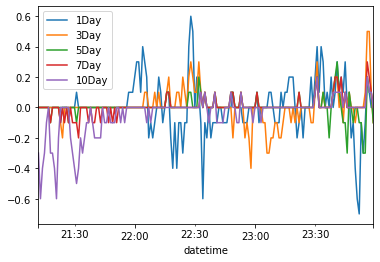

In [281]:
weeklyhlNewPct.iloc[-168:].plot()

## 平滑数据（smooth）

In [277]:
# def smooth(series, fast=20, slow=100):
#     f = ta.MA(series.values, fast)
#     s = ta.MA(series.values, slow)
#     return pd.DataFrame({"fast": f, "slow": s}, series.index)

# def plot_smooth(ax, smoothed, origin):
#     ax.set_title(origin.name)
#     ax.bar(origin.index, origin.values, alpha=0.05)
#     ax.plot(smoothed.slow, c='r', label = 'slow')
#     ax.plot(smoothed.fast, c='g', label = 'fast')
#     ax.legend()
#     return ax

## 4_如何用图形展示市场宽度？

### 读取数据

In [278]:
# import numpy as np
# btcDf = crytoPn['btc']
# btcDf["trend"] = trend
# btcDf["participation"] = participation
# btcDf["leadership"] = leadership

In [279]:
# btcDf

In [280]:
# import matplotlib.pyplot as plt

# f, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

# axs[0].set_title("btc")
# axs[0].plot(btcDf['close'])

# to_smooth = ["trend", "participation", "leadership"]

# for ax, (name, item) in zip(axs[1:], btcDf[to_smooth].iteritems()):
#     plot_smooth(ax, smooth(item), item)

# plt.show()